# Housing Price Study Notebook

## Objectives
- Answer business requirement 1:
    - The client is interested in discovering how the house attributes correlate with the sale price. Therefore, the client expects data visualisations of the correlated variables against the sale price to show that.

# Inputs

- outputs/datasets/collection/HousingPrices.csv

## Outputs
- Generate code that answers business requirement 1 and can be used to build the Streamlit App

---

## Change working directory
Change current working directory to its parent

In [1]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")

You set a new current working directory


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Load Data

In [7]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousingPrices.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1717,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2198,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Data Exploration

In [8]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:00<00:00, 153.12it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation Study

### Spearman and Pearson Methods on Numerical Variables

In [18]:
numeric_features = df.select_dtypes(include=['number'])
corr_spearman = numeric_features.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson = numeric_features.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)

In [19]:
corr_pearson

OverallQual     0.790982
TotalSF         0.772116
GrLivArea       0.708624
AboveGradeSF    0.704381
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
HouseAge       -0.522897
RemodAge       -0.507101
MasVnrArea      0.472614
Name: SalePrice, dtype: float64

In [20]:
corr_spearman

OverallQual     0.809829
TotalSF         0.804128
GrLivArea       0.731310
AboveGradeSF    0.721304
HouseAge       -0.652682
GarageArea      0.649379
TotalBsmtSF     0.602725
1stFlrSF        0.575408
RemodAge       -0.571159
OpenPorchSF     0.477561
Name: SalePrice, dtype: float64

In [21]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'AboveGradeSF',
 'GarageArea',
 'GrLivArea',
 'HouseAge',
 'OverallQual',
 'TotalSF'}

In [41]:
vars_to_study = ['AboveGradeSF', 'GarageArea', 'GrLivArea', 'HouseAge', 'OverallQual', 'TotalSF']

### Group Analysis and Box Plots on Categorical Variables

In [25]:
%matplotlib inline

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import seaborn as sns

def auto_order_encode_plot(df, target, cat_cols):
    for col in cat_cols:
        median_order = df.groupby(col)[target].median().sort_values()
        order = list(median_order.index)
        
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=col, y=target, data=df, order=order)
        plt.title(f"{target} distribution by {col} (ordered by median)")
        plt.xticks(rotation=45)
        plt.show()
        
        mapping = {k: v for v, k in enumerate(order, 1)}
        new_col_name = col + '_encoded'
        df[new_col_name] = df[col].map(mapping)
        
        print(f"Encoded '{col}' as '{new_col_name}' with mapping:\n{mapping}\n")

        print(df.groupby(col)['SalePrice'].mean().sort_values())
    return df


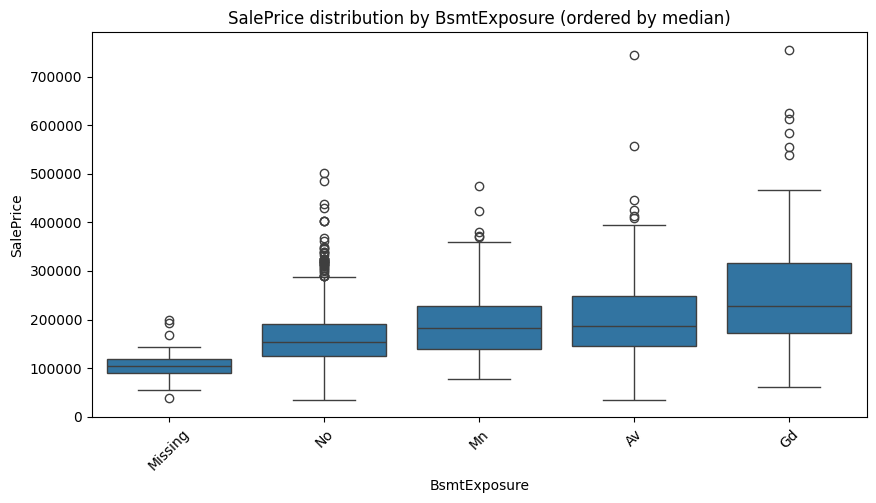

Encoded 'BsmtExposure' as 'BsmtExposure_encoded' with mapping:
{'Missing': 1, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5}

BsmtExposure
Missing    107938.342105
No         165652.295908
Mn         192789.657895
Av         206643.420814
Gd         257689.805970
Name: SalePrice, dtype: float64


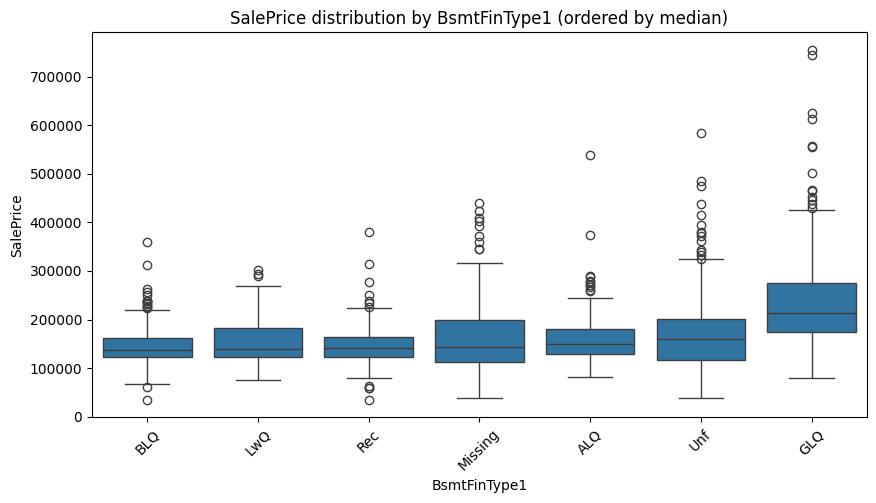

Encoded 'BsmtFinType1' as 'BsmtFinType1_encoded' with mapping:
{'BLQ': 1, 'LwQ': 2, 'Rec': 3, 'Missing': 4, 'ALQ': 5, 'Unf': 6, 'GLQ': 7}

BsmtFinType1
Rec        147424.365079
BLQ        148109.272059
LwQ        152565.714286
ALQ        162468.935644
Missing    168205.531034
Unf        170223.898990
GLQ        234103.438961
Name: SalePrice, dtype: float64


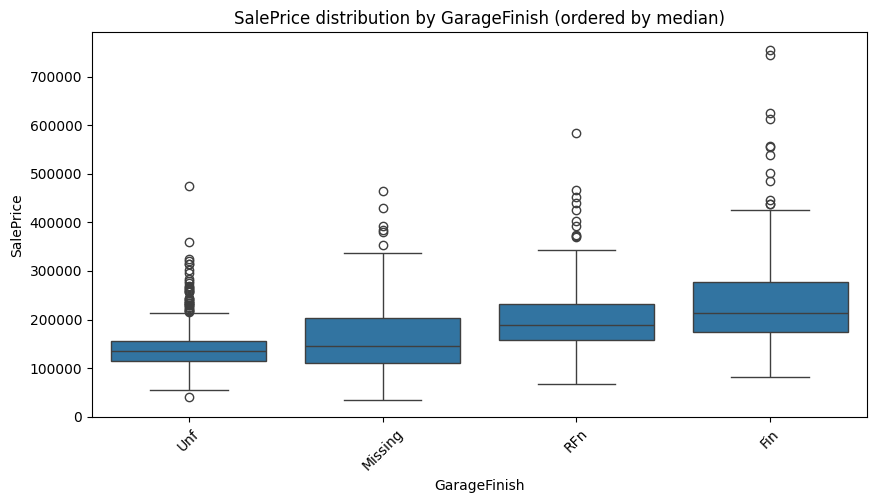

Encoded 'GarageFinish' as 'GarageFinish_encoded' with mapping:
{'Unf': 1, 'Missing': 2, 'RFn': 3, 'Fin': 4}

GarageFinish
Unf        140782.774725
Missing    166003.761702
RFn        201374.792350
Fin        238222.022364
Name: SalePrice, dtype: float64


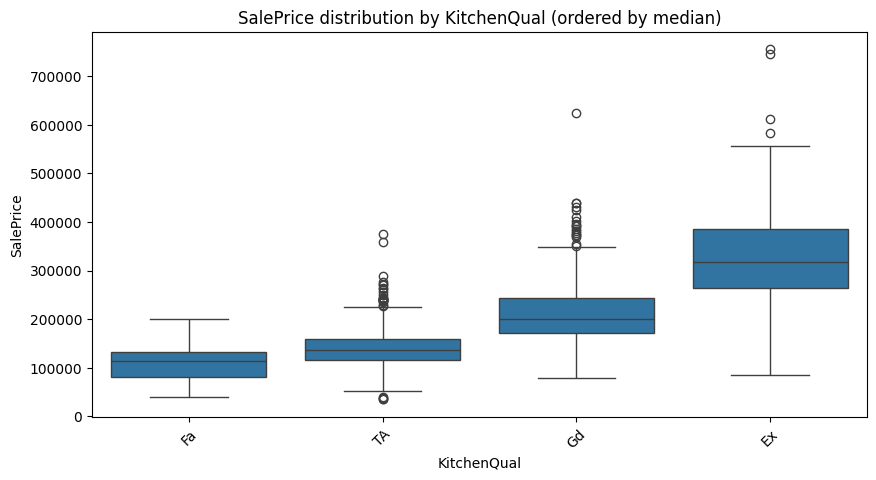

Encoded 'KitchenQual' as 'KitchenQual_encoded' with mapping:
{'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

KitchenQual
Fa    105565.205128
TA    139962.511565
Gd    212116.023891
Ex    328554.670000
Name: SalePrice, dtype: float64


In [35]:
categorical_features = df.select_dtypes(include=['object']).columns
df = auto_order_encode_plot(df, target='SalePrice', cat_cols=categorical_features.to_list())

Observations:
- The relationship between categories of BsmtFinType1 and SalePrice isn't monotonic
- BsmtExposure, GarageFinish and KitchenQual have a monotonic relationship with SalePrice and should be included for further investigation

In [42]:
vars_to_study += ['BsmtExposure', 'GarageFinish', 'KitchenQual']
vars_to_study

['AboveGradeSF',
 'GarageArea',
 'GrLivArea',
 'HouseAge',
 'OverallQual',
 'TotalSF',
 'BsmtExposure',
 'GarageFinish',
 'KitchenQual']

## EDA on selected variables

In [48]:
num_vars = ['AboveGradeSF', 'GarageArea', 'GrLivArea', 'HouseAge', 'OverallQual', 'TotalSF']
cat_vars = ['BsmtExposure', 'GarageFinish', 'KitchenQual']

### Numerical Variables

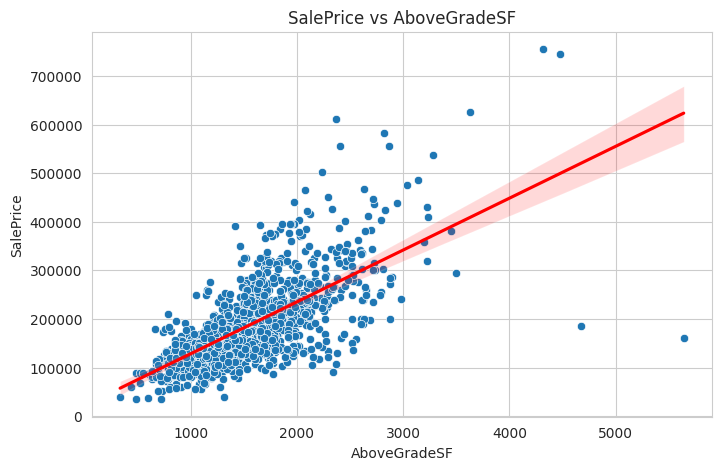

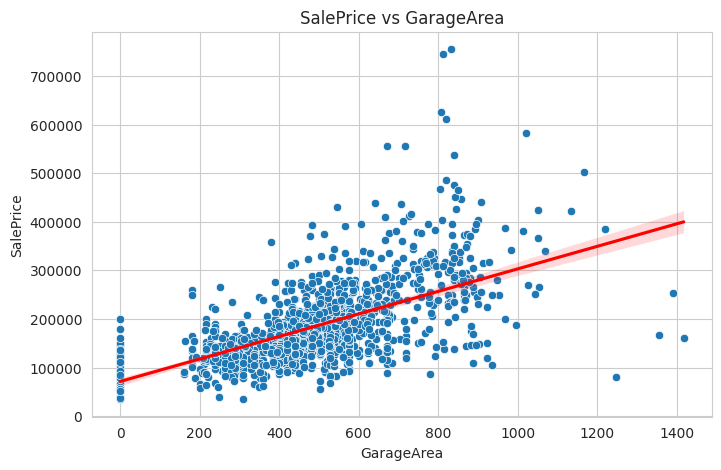

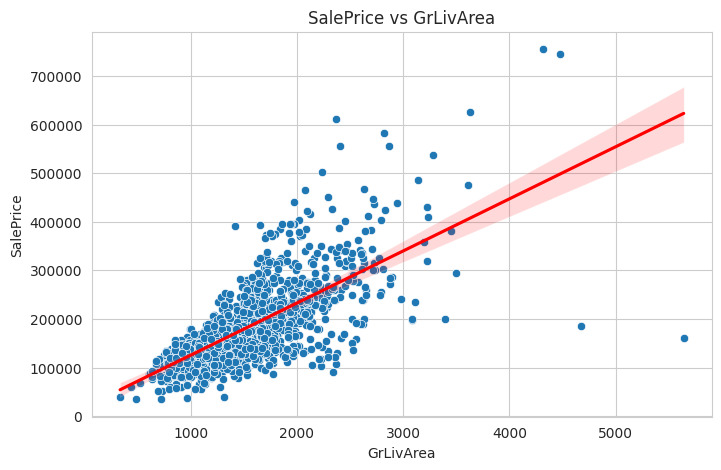

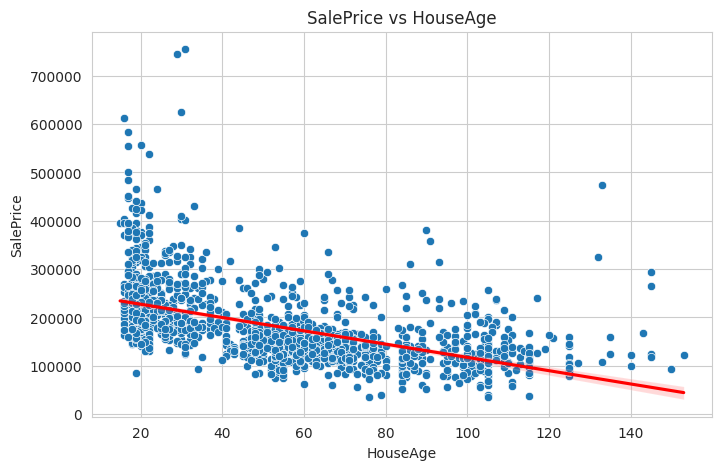

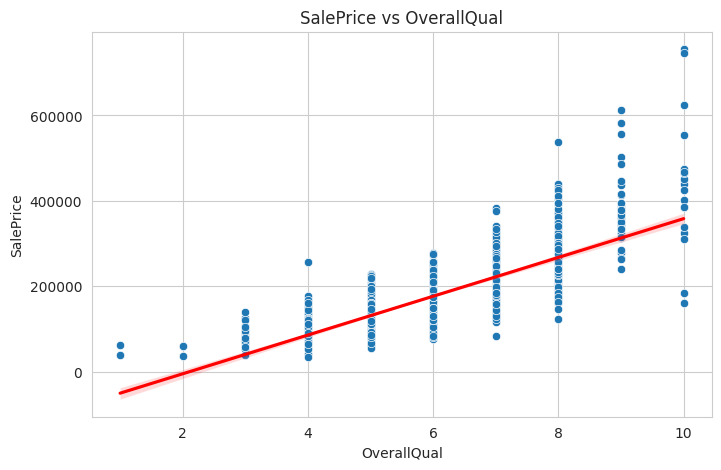

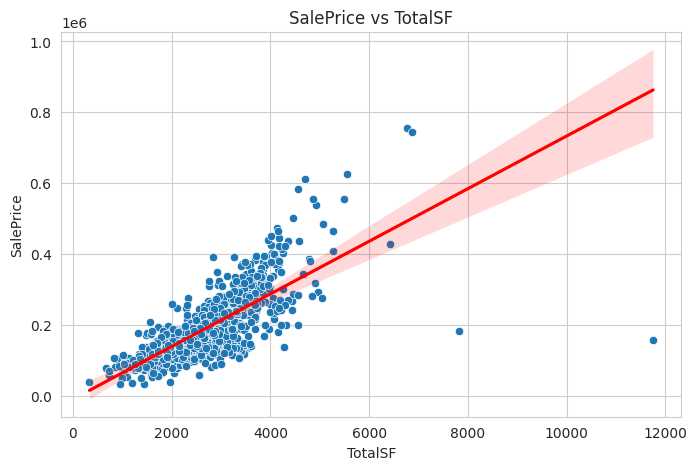

In [ ]:
for var in num_vars:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=var, y='SalePrice', data=df)
    sns.regplot(x=var, y='SalePrice', data=df, scatter=False, color='red')
    plt.title(f'SalePrice vs {var}')
    plt.show()

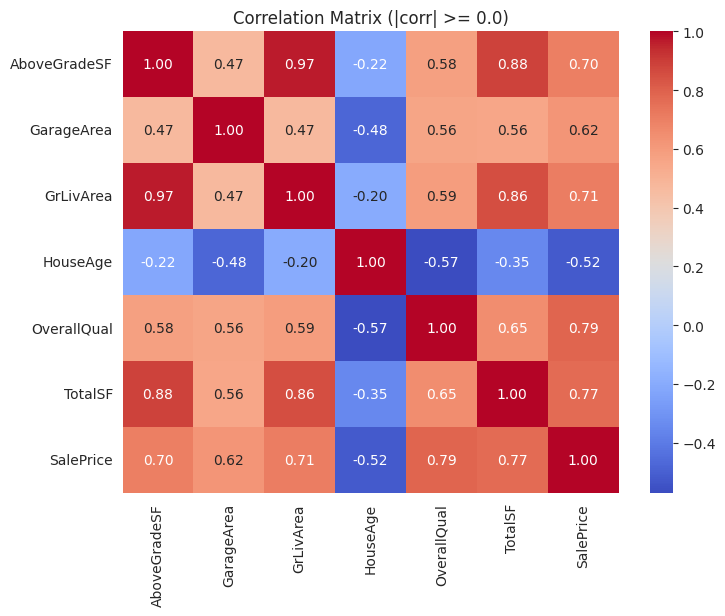

In [57]:
import numpy as np

corr = df[num_vars + ['SalePrice']].corr()
threshold = 0.0
mask = np.abs(corr) < threshold
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar=True)
plt.title(f"Correlation Matrix (|corr| >= {threshold})")
plt.show()

Observations:
- OveralQual has the strongest correlation with SalePrice, following by TotalSF
- HouseAge has an inverse relationship with SalePrice
